In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
# read telescope_data

telescope_data = pd.read_csv("datasets/telescope_data.csv", index_col=0)
telescope_data = telescope_data.sample(frac=1).reset_index(drop=True)
# telescope_data.head()

In [361]:
# data rebalancing
class_col = "class"
gamma = telescope_data[telescope_data[class_col] == 'g']
hadron_rows = telescope_data[class_col].value_counts().iloc[0] # number of hadron samples
gamma_rows = telescope_data[class_col].value_counts().iloc[1]  # number of gamma samples 

telescope_data = telescope_data.drop(telescope_data[telescope_data[class_col].eq('g')].sample(hadron_rows - gamma_rows).index)

X = telescope_data.iloc[:,:-1]
y = telescope_data[class_col]

# Z-score Standardization
X_mean = X.mean()
X_std = X.std()
X_standardized = (X - X_mean) / X_std

telescope_data = pd.concat([X_standardized, y], axis=1)
telescope_data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,-0.373582,-0.460903,-0.114149,-0.463192,-0.472556,-0.504988,-0.498194,-0.315889,-1.090757,-0.694273,g
1,1.540369,-0.301443,0.123614,-0.074152,0.176279,-0.723546,-2.373830,-0.224196,-0.708786,-1.858892,h
3,1.653737,2.647859,1.264919,-0.572189,-0.878853,-1.805672,1.721960,2.162785,1.564356,1.743347,h
6,-0.637373,-0.342118,-0.030270,0.037542,-0.067145,0.474430,0.232650,0.451282,0.068589,-0.390832,h
7,0.744872,1.350855,2.489473,-1.381566,-1.355079,0.218973,0.350466,1.423386,-1.025457,1.876793,g
...,...,...,...,...,...,...,...,...,...,...,...
19014,-0.659047,-0.346852,-0.498648,0.317587,-0.034393,-0.368691,-0.632066,0.561082,1.744198,-1.808462,h
19016,1.796393,0.931872,-0.115621,-0.060123,-0.163629,2.137732,0.902935,-1.337732,-1.052827,1.378115,h
19017,1.218418,0.871070,0.555204,-0.833348,-0.841676,1.912054,1.374761,0.978546,-0.169989,-0.362055,h
19018,-0.231656,-0.037870,0.113523,-0.770216,-0.708014,0.885571,0.398999,0.286148,1.837527,-0.128653,h


In [367]:
#splitting data

total_rows = telescope_data.shape[0]

training_set_ratio = 0.7
validation_set_ratio = 0.15
test_set_ratio = 0.15

training_end = int(total_rows * training_set_ratio)
validation_end = int(total_rows * (training_set_ratio + validation_set_ratio))

training_set = telescope_data[:training_end]
validation_set = telescope_data[training_end:validation_end]
test_set = telescope_data[validation_end:]

# display(training_set)
# display(validation_set)
# display(test_set)

In [368]:
# KNN Classifier Manually

from collections import Counter

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.to_numpy()
        self.y_train = y.to_numpy()

    def predict(self, X):
        X = X.to_numpy()
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _predict(self, x):
        # compute the distance
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]

        # get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # majority vote
        most_common = Counter(k_nearest_labels).most_common(self.k)
        return most_common[0][0]

classifier = KNN(k=25)
classifier.fit(training_set.iloc[:, :-1], training_set[class_col])
predictions = classifier.predict(validation_set.iloc[:, :-1])

print(predictions)

['g' 'g' 'h' ... 'g' 'h' 'h']


Accuracy: 79.86%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.760033  0.885965  0.818182
1     h   0.855556  0.707143  0.774302

Confusion Matrix:


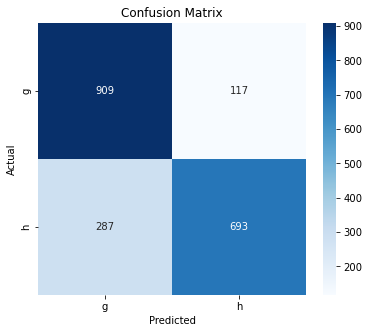

In [369]:
# classification evaluation

def evaluate_classification(y_target, y_predicted):
    
    y_target = np.array(y_target)
    y_predicted = np.array(y_predicted)

    # get classes
    classes = np.unique(np.concatenate((y_target, y_predicted)))

    # initialize confusion_matrix
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    # fill confusion_matrix
    for i in range(len(y_target)):
        true_idx = np.where(classes == y_target[i])[0][0]
        pred_idx = np.where(classes == y_predicted[i])[0][0]
        conf_matrix[true_idx, pred_idx] += 1
    
    # per-class metrics
    precision = []
    recall = []
    f1 = []

    for i in range(len(classes)):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP

        prec = TP / (TP + FP) if (TP + FP) != 0 else 0
        rec = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1.append(f1_score)

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    # summarize results
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

    return accuracy, metrics_df, conf_matrix

y_target = validation_set[class_col].to_numpy()
y_predicted = predictions
accuracy, metrics_df, conf_matrix = evaluate_classification(y_target,y_predicted)

print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)
print("\nConfusion Matrix:")
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [370]:
# KNN implementation using scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Separate features and target
X = telescope_data.iloc[:, :-1]
Y = telescope_data[class_col]

# Step 1: Split into training + temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=0
)

# Step 2: Split the temp data into validation and test sets equally (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0
)

clf = KNeighborsClassifier(n_neighbors=25)
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
print("validation set predictions: {}".format(y_val_pred))

validation set predictions: ['g' 'h' 'h' ... 'h' 'h' 'g']


In [371]:
print("validation set accuracy: {:.2f}%".format(clf.score(X_val, y_val) * 100))

validation set accuracy: 80.11%


Validation Accuracy: 80.11%

Classification Report:
              precision    recall  f1-score   support

           g       0.75      0.90      0.82       983
           h       0.88      0.70      0.78      1023

    accuracy                           0.80      2006
   macro avg       0.81      0.80      0.80      2006
weighted avg       0.82      0.80      0.80      2006



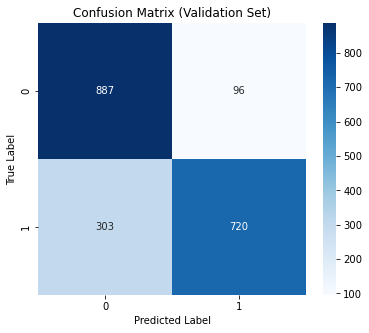

In [372]:
# classification evaluation with scikit-learn

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()